# Bayesian vs Machine Learning Classification Comparison 

### Sabrina Pereira and Ashley Swanson

This notebook explores the differences between the classification outcomes of a machine learning classifier and a naive Bayesian classifier. To do this, we implement the KNN Neighbors Classifier to output roughly the same precision and recall as a naive Bayesian classifier and analyze the similarities and differences of misclassified data points.

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from scipy.stats import gaussian_kde

from thinkstats2 import Pmf, Cdf, Hist
import thinkplot

from utils import decorate

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt 

## Loading Data

The iris dataset is one of the most widely used datasets for classification. It was originally collected by Edgar Anderson in 1935, and used in R. A. Fisher’s paper [The Use of Multiple Measurements in Taxonomic Problems](http://rcs.chemometrics.ru/Tutorials/classification/Fisher.pdf). This dataset can be downloaded directly from scikit learn.

Anderson recorded four key physical features for three flowers. The following codes correspond to each flower. 

##### 0=setosa, 1=versicolor, 2=virginica

In [7]:
iris = datasets.load_iris()

X = iris.data
y = iris.target

df0 = pd.DataFrame(X, columns=iris.feature_names)
df = pd.DataFrame(X, columns=iris.feature_names)
df['flower'] = y

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),flower
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [8]:
setosa = df[df.flower == 0]
versicolor = df[df.flower == 1].reset_index(drop=True)
virginica = df[df.flower == 2].reset_index(drop=True)

## Data Exploration

To start, we examine a given feature and plot the distribution of measurements for each flower on one plot. This allows for comparision between distributions, and it gives us some sense of what the decisions boundries might be like for our classifiers. We do the same for the remaining three features. 

/home/spereira/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


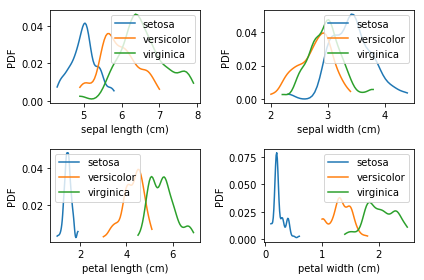

In [4]:
for fl in [setosa,versicolor,virginica]:

    
    for i, feature in enumerate(iris.feature_names):

        kde = gaussian_kde(fl[feature],bw_method=0.3)

        xs = np.linspace(fl[feature].min(), fl[feature].max())
        ds = kde.evaluate(xs)
        ds /= ds.sum()

        plt.subplot(2,2,i+1)

        plt.plot(xs, ds, label=iris.target_names[fl.flower[0]])

        decorate(xlabel=feature, ylabel='PDF')

From this figure, we can see that some features seem to be more valuable for distinquishing flower types than others. 

For example, in the petal width plot, setosa has no overlap with the other flowers. This means that, within this dataset, setosa is enirely distinguishable from the other flowers with no further information. Versicolor and virginica have little overlap, meaning that petal width would be a good indicator, but there is information to be gained from the features to increase performance.

On the other hand, in the sepal width plot, versicolor and virginica are primarliy overlapping. We will see how ou differnt classiffiers take all of this information into account!

## Classification 

In [10]:
def Bayesian(seed, bayes_df):
    
    actual = []
    guess = []
    index = []
    
    X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

    bayes = GaussianNB()
    
    bayes.fit(X_train, y_train)
    y_pred = bayes.predict(X_test)
    mis_class = y_pred-y_test
    
    for i in range(len(mis_class)):
        if(mis_class[i]!=0):
            actual.append(y_test[i])
            guess.append(y_pred[i])
            index.append(X.tolist().index(X_test[i].tolist()))
    temp = pd.DataFrame({'actual':actual, 'guess':guess, 'flower_index':index})

    
#     return temp
    
    return (bayes.score(X_test, y_test), temp) 

In [12]:
bayes_df = pd.DataFrame() 
scores = []

for i in range (0, 1000):
    s = Bayesian(i, bayes_df)[0]
    temp = Bayesian(i, bayes_df)[1]

    scores.append(s)    
    bayes_df = bayes_df.append(temp, ignore_index=True)
    
print(np.mean(scores))
# print(bayes_df)

0.9532666666666667


In [13]:
def  KNeighbors(seed, n, knn_df):
    actual = []
    guess = []
    index = []
    
    X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    mis_class = y_pred-y_test
    
    for i in range(len(mis_class)):
        if(mis_class[i]!=0):
            actual.append(y_test[i])
            guess.append(y_pred[i])
            index.append(X.tolist().index(X_test[i].tolist()))
    temp = pd.DataFrame({'actual':actual, 'guess':guess, 'flower_index':index})
            
    return (knn.score(X_test, y_test), temp)
            

In [22]:
knn_df = pd.DataFrame() 
for k in range(1, 20):
    scores = []

    for i in range (0, 1000):
        s = KNeighbors(i, k, knn_df)[0]
        scores.append(s)

    print(k, ":", np.mean(scores))

1 : 0.9569777777777779
2 : 0.9465777777777779
3 : 0.9614444444444445
4 : 0.9576222222222223
5 : 0.9640444444444445
6 : 0.9614
7 : 0.9647777777777778
8 : 0.9628222222222222
9 : 0.9666444444444445
10 : 0.9629333333333334
11 : 0.967
12 : 0.9636444444444446
13 : 0.9668666666666668
14 : 0.9625555555555556
15 : 0.965288888888889
16 : 0.959088888888889
17 : 0.9609777777777778
18 : 0.9547111111111112
19 : 0.9565111111111112


From this test, we can see that we should select 4 or 18 neighbors to get the same accuracy levels as our Bayesian classifier. 

In [24]:
knn_df = pd.DataFrame() 
scores = []

for i in range (0, 1000):
    s = KNeighbors(i, 18, knn_df)[0]
    temp = KNeighbors(i, 18, knn_df)[1]
    
    scores.append(s)
    knn_df = knn_df.append(temp, ignore_index=True)


print(np.mean(scores))

0.9547111111111112


In [75]:
bayes_df.head()

,actual,guess,flower_index
0,2.0,1.0,134.0
1,2.0,1.0,106.0
2,2.0,1.0,134.0
3,1.0,2.0,77.0
4,2.0,1.0,119.0


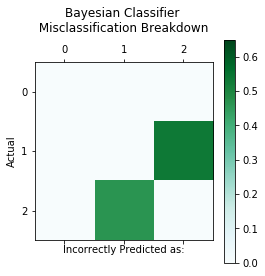

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.53399905],
       [0.        , 0.46600095, 0.        ]])

In [27]:
b = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(0, int(bayes_df.size/3)):
    x = int(bayes_df.iloc[i]['actual'])
    y = int(bayes_df.iloc[i]['guess'])
    b[y][x] += 1
A = np.array(b)/int(bayes_df.size/3)

plt.matshow(A, vmin=0, vmax=.65, cmap='BuGn')       # same
plt.colorbar()
plt.title('Bayesian Classifier \n Misclassification Breakdown \n')
plt.xlabel('Incorrectly Predicted as:')
plt.ylabel('Actual')
plt.show()

A

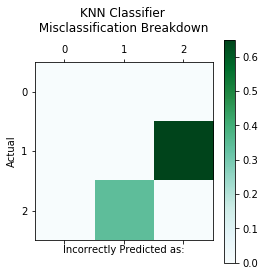

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.65799804],
       [0.        , 0.34200196, 0.        ]])

In [28]:
k = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(0, int(knn_df.size/3)):
    x = int(knn_df.iloc[i]['actual'])
    y = int(knn_df.iloc[i]['guess'])
    k[y][x] += 1
K = np.array(k)/int(knn_df.size/3)

plt.matshow(K, vmin=0, vmax=.65, cmap='BuGn')       # same
plt.colorbar()
plt.title('KNN Classifier \n Misclassification Breakdown \n')
plt.xlabel('Incorrectly Predicted as:')
plt.ylabel('Actual')
plt.show()

K

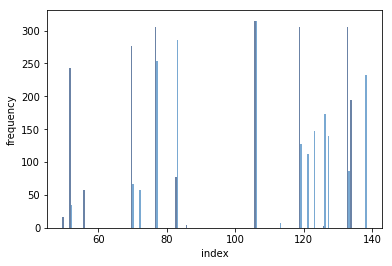

Hist({106.0: 315, 119.0: 306, 133.0: 306, 77.0: 305, 70.0: 277, 52.0: 243, 134.0: 194, 83.0: 78, 56.0: 57, 50.0: 16, 86.0: 4, 126.0: 2})
Hist({106.0: 315, 83.0: 286, 77.0: 253, 138.0: 232, 126.0: 173, 123.0: 148, 127.0: 140, 119.0: 128, 121.0: 112, 133.0: 86, 70.0: 66, 72.0: 57, 52.0: 35, 113.0: 7})


<Figure size 576x432 with 0 Axes>

In [54]:
bayes_hist = Hist(bayes_df.flower_index)#, label = 'bayes')
knn_hist = Hist(knn_df.flower_index)#, label = 'knn')

width =.45
thinkplot.PrePlot()
thinkplot.Hist(bayes_hist, align='right', width=width)
thinkplot.Hist(knn_hist, align='left', width=width)
thinkplot.Show(xlabel='index', ylabel='frequency')
# xlim=[150,200]

print(bayes_hist)
print(knn_hist)

In [200]:
df.iloc[1]

sepal length (cm)    4.9
sepal width (cm)     3.0
petal length (cm)    1.4
petal width (cm)     0.2
flower               0.0
Name: 1, dtype: float64

In [44]:
for feature in (iris.feature_names):
    print(feature, ":", '   setosa', round(np.mean(setosa[feature]),2), '   versicolor', 
          round(np.mean(versicolor[feature]),2), '   virginica', round(np.mean(virginica[feature]),2),'\n')

sepal length (cm) :    setosa 5.01    versicolor 5.94    virginica 6.59 

sepal width (cm) :    setosa 3.43    versicolor 2.77    virginica 2.97 

petal length (cm) :    setosa 1.46    versicolor 4.26    virginica 5.55 

petal width (cm) :    setosa 0.25    versicolor 1.33    virginica 2.03 



In [52]:
print("Flower: ", iris.target_names[int(df.iloc[106]['flower'])], '\n')

for feature in (iris.feature_names):
    print(feature, ":", df.iloc[106][feature])

Flower:  virginica 

sepal length (cm) : 4.9
sepal width (cm) : 2.5
petal length (cm) : 4.5
petal width (cm) : 1.7


In [55]:
print("Flower: ", iris.target_names[int(df.iloc[138]['flower'])], '\n')
for feature in (iris.feature_names):
    print(feature, ":", df.iloc[138][feature])

Flower:  virginica 

sepal length (cm) : 6.0
sepal width (cm) : 3.0
petal length (cm) : 4.8
petal width (cm) : 1.8


In [57]:
print("Flower: ", iris.target_names[int(df.iloc[134]['flower'])], '\n')
for feature in (iris.feature_names):
    print(feature, ":", df.iloc[134][feature])

Flower:  virginica 

sepal length (cm) : 6.1
sepal width (cm) : 2.6
petal length (cm) : 5.6
petal width (cm) : 1.4
